# Categorizing Countries Based on Socio-Economic and Health Factors 

#### Importing all the necessary libraries

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for scaling
import sklearn
from sklearn.preprocessing import StandardScaler

#for hopkins statistics
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

#for PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

#for K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#for Hierarchical
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

#### Reading the csv file

In [2]:
df = pd.read_csv('Country-data.csv')

## 1. Basic Understanding of the Data and Performing EDA

In [3]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
print('Shape --->', df.shape)
print(df.info())

Shape ---> (167, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB
None


* Out of 167, all are no-null. So we don't need to do any missing value imputation

In [5]:
#list of columns
cols = list(df)
print(cols)

['country', 'child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


#### Data Dictionary
* country: Name of the country
* child_mort: Death of children under 5 years of age per 1000 live births
* exports: Exports of goods and services. Given as %age of the Total GDP
* health: Total health spending as %age of Total GDP
* imports: Imports of goods and services. Given as %age of the Total GDP
* Income: Net income per person
* Inflation: The measurement of the annual growth rate of the Total GDP
* life_expec: The average number of years a new born child would live if the current mortality patterns are to remain the same
* total_fer: The number of children that would be born to each woman if the current age-fertility rates remain the same.
* gdpp: The GDP per capita. Calculated as the Total GDP divided by the total population.

#### Problem:
* 'exports', 'health', and 'imports' are given as %age of the total GDP but the total GDP is not given

#### Solution:
* Let's assume 'GDP' is the total GDP of a country, population is 'P' and 'GDPP' is the GDP per capita.
* So, GDPP = GDP/P
* As per the 'Data Dictonary', the 'exports' column is the %age (let's assume X% for country 'C') of the total GDP.
* So, the absolute value of exports for C = GDP*X/100
* Thus exports per person = (GDP * X)/(100 * P) = GDPP*X/100
* Conclusion: Although we do not have the total GDP available, we can apply (GDPP*X/100) safely to correct the 'exports', 'health', and 'imports' columns

In [6]:
#Let's convert %age to absolute values for 'exports', 'health', and 'imports' columns
df_corrected = df.copy()
df_corrected['exports'] = df_corrected['exports']*df_corrected['gdpp']/100
df_corrected['health'] = df_corrected['health']*df_corrected['gdpp']/100
df_corrected['imports'] = df_corrected['imports']*df_corrected['gdpp']/100
df_corrected.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [7]:
df_corrected.describe(include = 'all')

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
unique,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,NaN,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,NaN,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,NaN,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,NaN,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,NaN,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000


In [8]:
#'exports' is a positive contributer in GDP but the 'imports' is the negative one.
#So, we can reduce the dimension (while not loosing any information) of the dataset by generating new varible 
#'net_exports' which is 'exports' minus 'imports'
df_corrected1 = df_corrected.copy()
df_corrected1['net_exports'] = df_corrected1['exports'] - df_corrected1['imports']
df_corrected1 = df_corrected1.drop(['exports', 'imports'], axis = 1)
df_corrected1.shape

(167, 9)

In [9]:
#attempt to identify numerical and non-numerical columns automatically
NonNumCols = []
NumCols = []

for col in list(df_corrected1):
    if df_corrected1[col].dtypes == 'object':
        NonNumCols.append(col)
    else:
        NumCols.append(col)
print('Non-Numerical columns:\n',NonNumCols)

print('Numerical columns:\n',NumCols)

Non-Numerical columns:
 ['country']
Numerical columns:
 ['child_mort', 'health', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'net_exports']


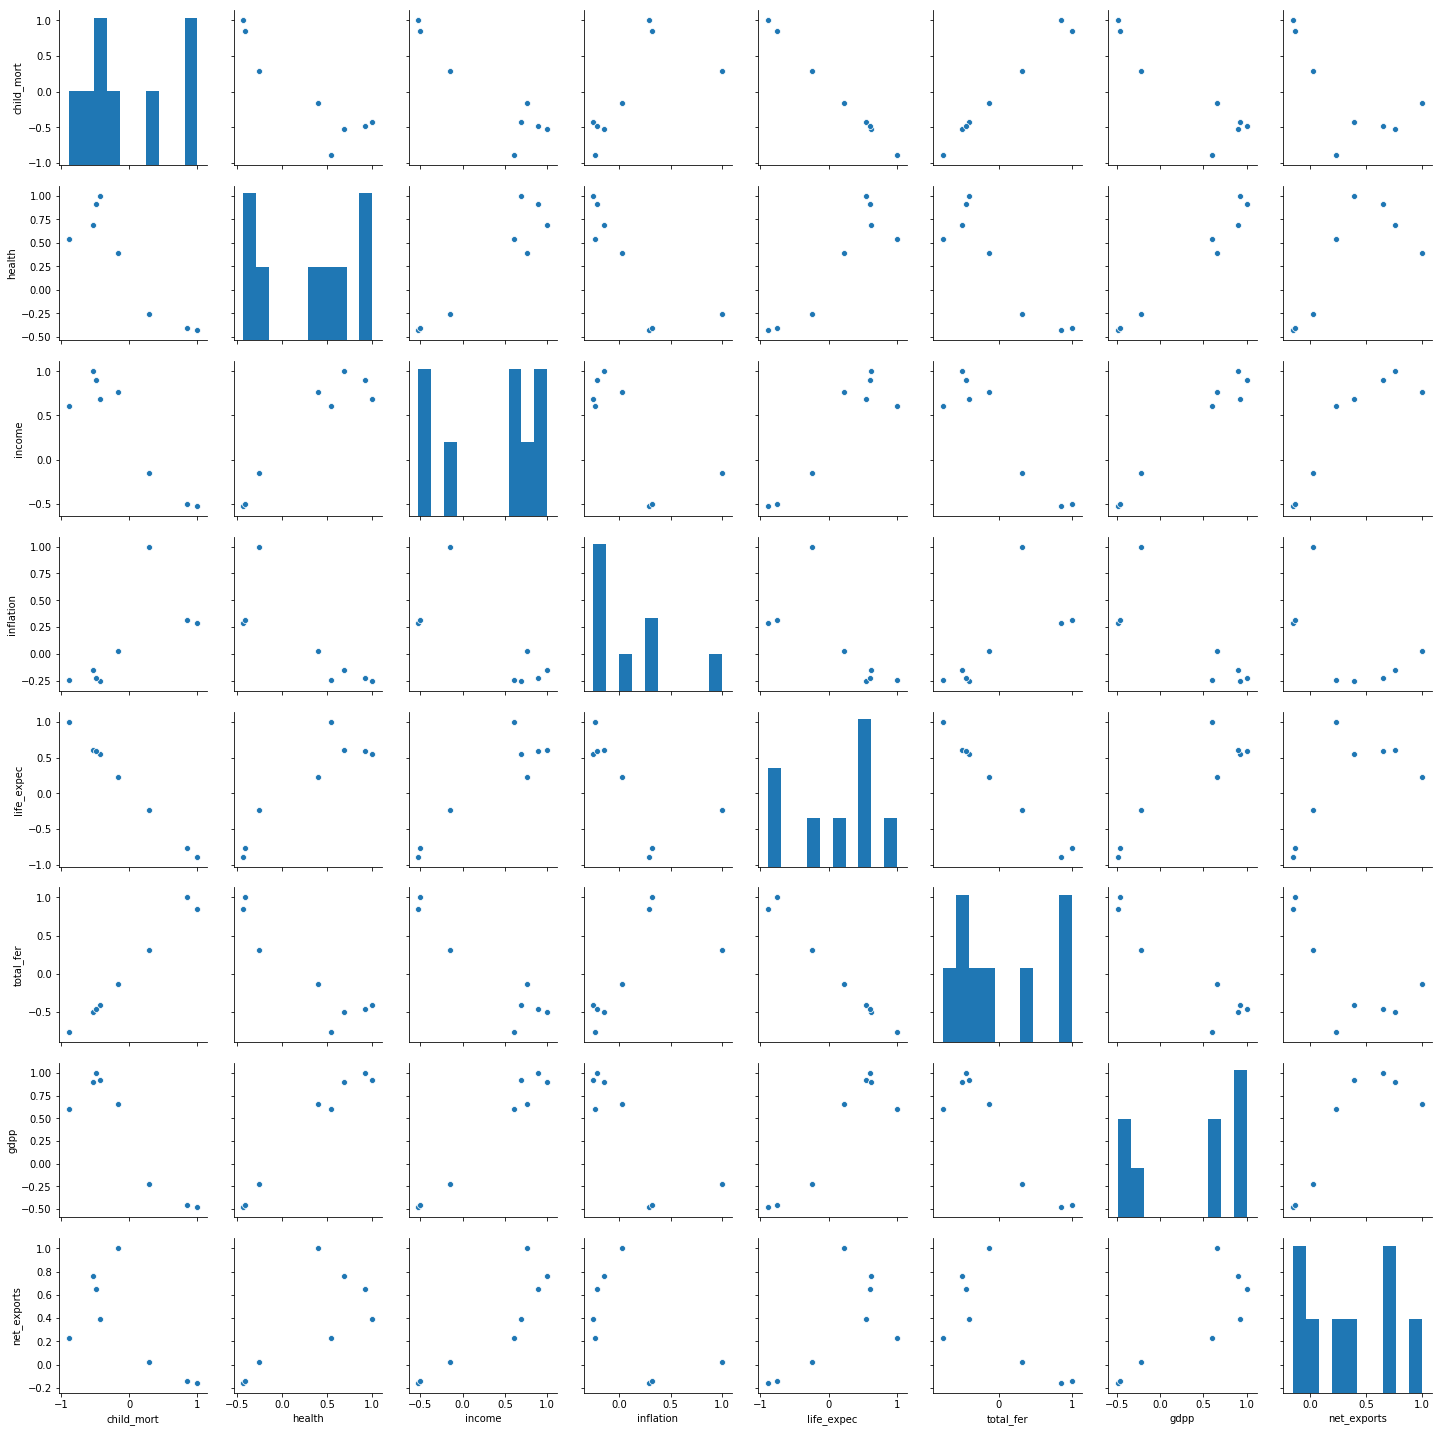

In [10]:
sns.pairplot(df_corrected1.corr())

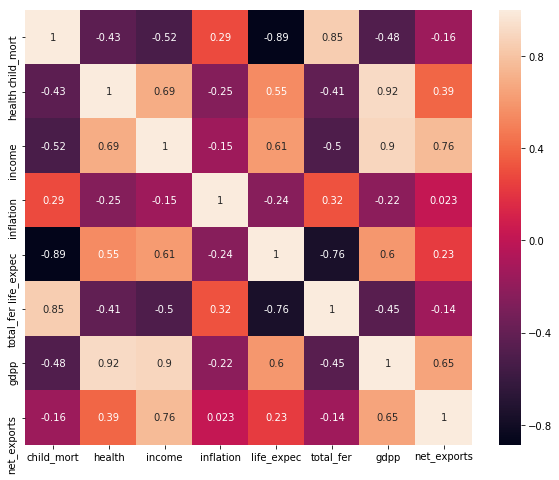

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df_corrected1.corr(), annot = True)

### Conclusion from the heatmap:
- Some variables are strongly correlated positively and some of them negatively
- The cell below identifies some top positive and negative correlations

In [12]:
#identifying top 5 positive & 5 negative correlations
corr = df_corrected1.corr()
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)) #finding the upper triangle
def prRed(skk): print("\033[91m {}\033[00m" .format(skk))
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk))
prGreen('\033[1m Top 5 positive correleation -------> \033[0m')
prGreen(upper_tri.stack().sort_values(ascending=False).head(5))
prRed('\033[1m Top 5 negative correleation -------> \033[0m')
prRed(upper_tri.stack().sort_values(ascending=True).head(5))

  Top 5 positive correleation -------> 
 health      gdpp           0.916593
income      gdpp           0.895571
child_mort  total_fer      0.848478
income      net_exports    0.760644
health      income         0.690857
dtype: float64
  Top 5 negative correleation -------> 
 child_mort  life_expec   -0.886676
life_expec  total_fer    -0.760875
child_mort  income       -0.524315
income      total_fer    -0.501840
child_mort  gdpp         -0.483032
dtype: float64


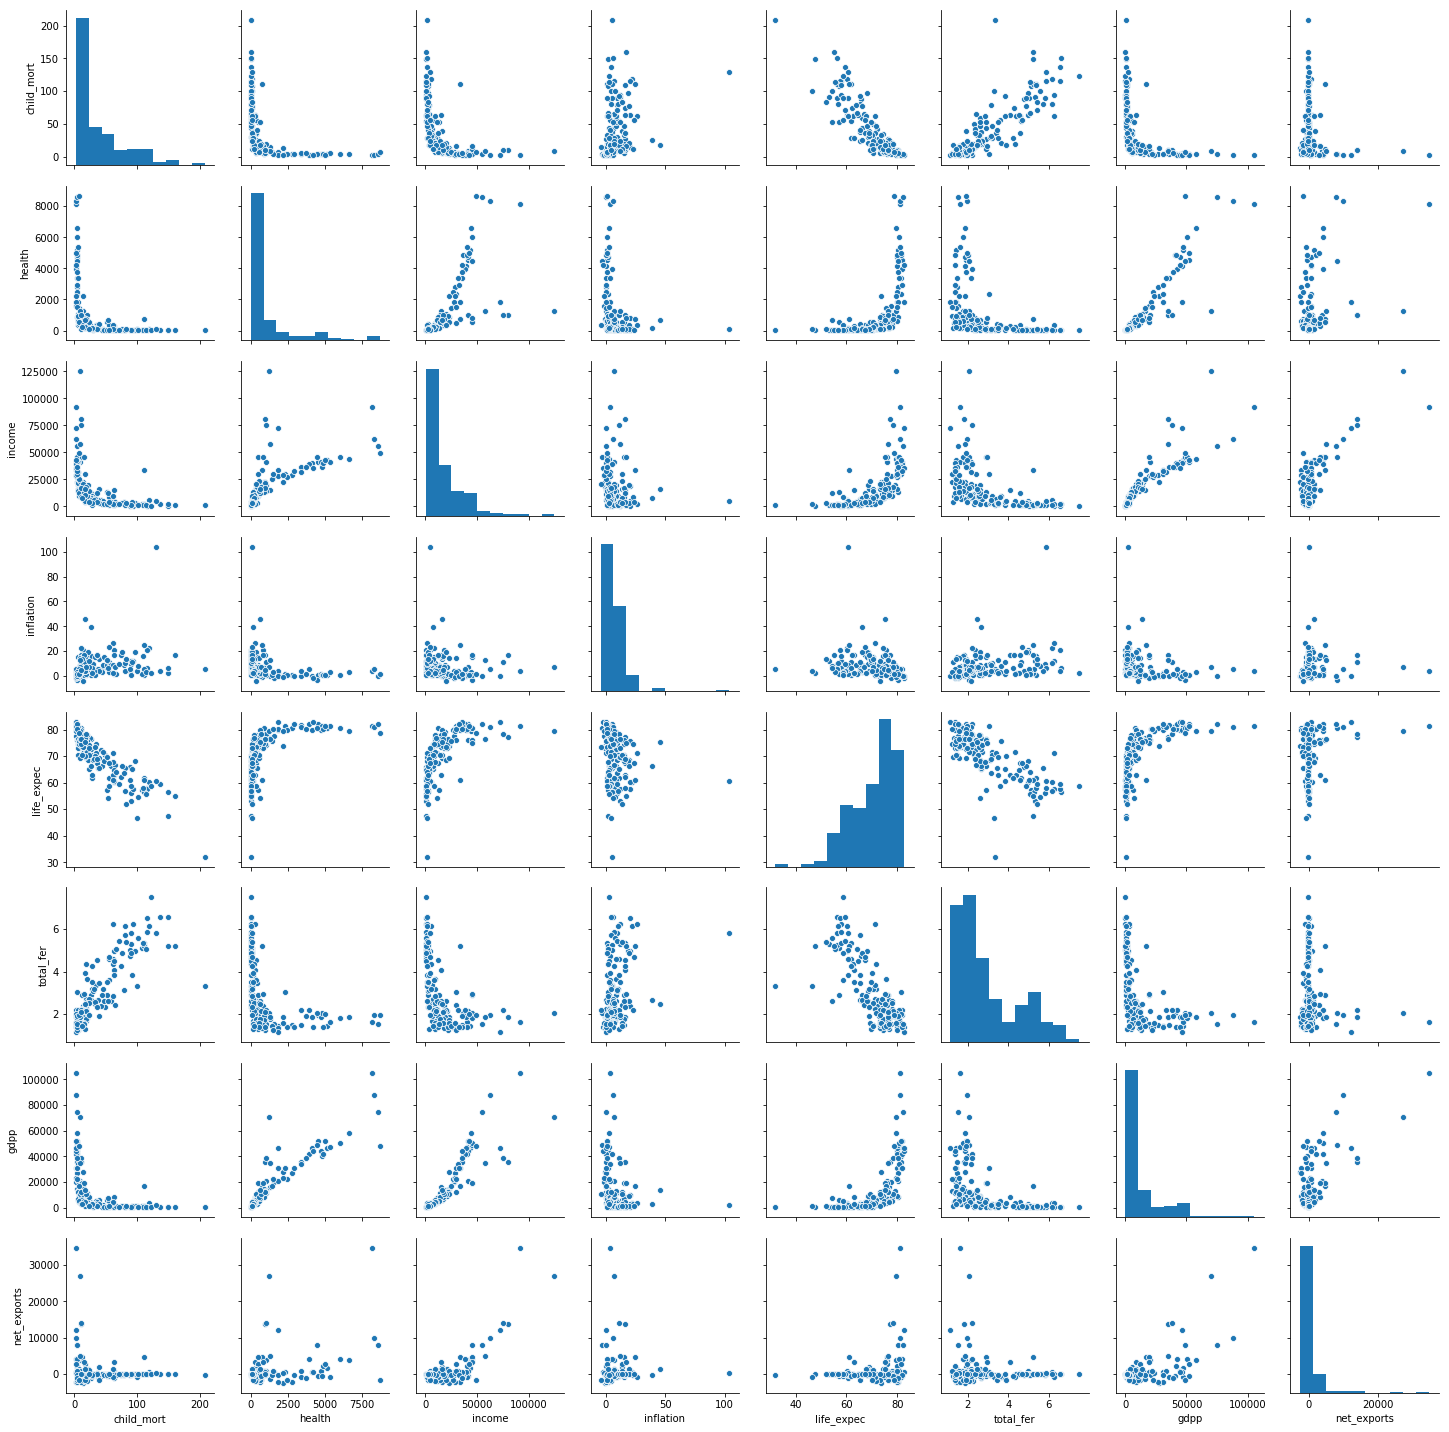

In [13]:
sns.pairplot(df_corrected1[NumCols])

Interestingly the pair plots above does not show any significant cluster formation

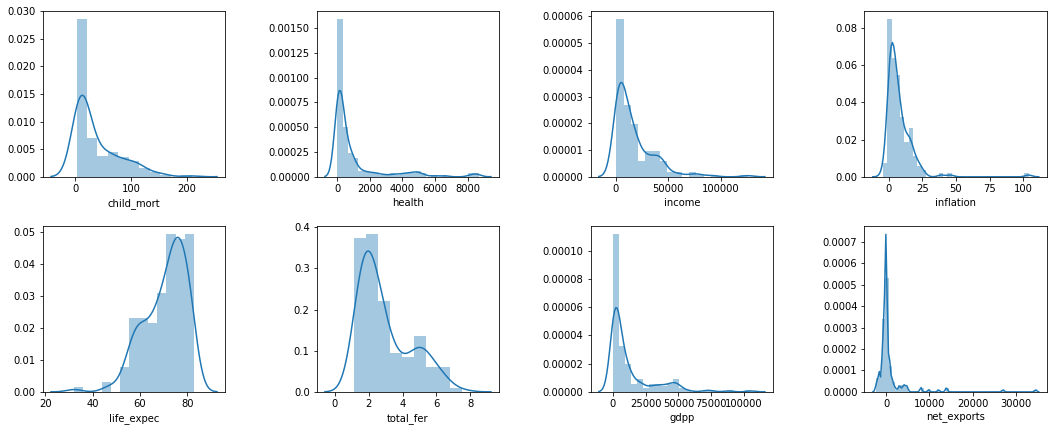

In [14]:
#let's visualize how the values are distributed in the numerical columns
plt.figure(figsize=(18,7))

for i in NumCols:
    plt.subplot(2, 4, (NumCols.index(i) + 1))
    sns.distplot(df_corrected1[i])
    plt.subplots_adjust(wspace = .5, hspace = .3)

## 2. Data preprocessing
### 2.1 Outlier Treatment

* From the distribution plots above it is evident (atleast statistically) that 'health', 'income', 'inflation', 'gdpp' and 'net_export' columns should go through outlier treatment.

In [15]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
df_corrected1[NumCols].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,net_exports
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,1056.733204,17144.688623,7.781832,70.555689,2.947964,12964.155689,832.266739
std,40.328931,1801.408906,19278.067698,10.570704,8.893172,1.513848,18328.704809,4142.403188
min,2.600000,12.821200,609.000000,-4.210000,32.100000,1.150000,231.000000,-2436.000000
25%,8.250000,78.535500,3355.000000,1.810000,65.300000,1.795000,1330.000000,-518.570000
50%,19.300000,321.886000,9960.000000,5.390000,73.100000,2.410000,4660.000000,-89.218200
75%,62.100000,976.940000,22800.000000,10.750000,76.800000,3.880000,14050.000000,327.050000
90%,100.220000,3825.416000,41220.000000,16.640000,80.400000,5.322000,41840.000000,3000.820000
95%,116.000000,4966.701000,48290.000000,20.870000,81.400000,5.861000,48610.000000,4873.050000
99%,153.400000,8410.330400,84374.000000,41.478000,82.370000,6.563600,79088.000000,18426.100000


In [16]:
#Countries above 95% percentile in the 'gdpp' column
print(list(df_corrected1[df_corrected1['gdpp'] > np.percentile(df_corrected1.gdpp,95)]['country']))

['Australia', 'Denmark', 'Ireland', 'Luxembourg', 'Netherlands', 'Norway', 'Qatar', 'Sweden', 'Switzerland']


In [17]:
#Countries above 95% percentile in 'net_exports' column
print(list(df_corrected1[df_corrected1['net_exports'] > np.percentile(df_corrected1.net_exports,95)]['country']))

['Brunei', 'Ireland', 'Kuwait', 'Luxembourg', 'Norway', 'Qatar', 'Singapore', 'Switzerland', 'United Arab Emirates']


In [18]:
#Countries above 95% percentile in the 'income' column
print(list(df_corrected1[df_corrected1['income'] > np.percentile(df_corrected1.income,95)]['country']))

['Brunei', 'Kuwait', 'Luxembourg', 'Norway', 'Qatar', 'Singapore', 'Switzerland', 'United Arab Emirates', 'United States']


In [19]:
#Countries above 95% percentile in the 'inflation' column
print(list(df_corrected1[df_corrected1['inflation'] > np.percentile(df_corrected1.inflation,95)]['country']))

['Angola', 'Argentina', 'Equatorial Guinea', 'Mongolia', 'Nigeria', 'Sri Lanka', 'Timor-Leste', 'Venezuela', 'Yemen']


In [20]:
#Countries above 95% percentile in the 'health' column
print(list(df_corrected1[df_corrected1['health'] > np.percentile(df_corrected1.health,95)]['country']))

['Austria', 'Canada', 'Denmark', 'Luxembourg', 'Netherlands', 'Norway', 'Sweden', 'Switzerland', 'United States']


* Infact all the above cases outliers are natural not the articial ones.
* So we will go ahead, first, without removal of the outliers and if we don't get good clustering, we will go for outlier treatment

### 2.2 Feature Scaling

In [21]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_corrected1[NumCols])
#df_scaled is a ndarray. we will convert it to a dataframe for easy handling
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = NumCols
df_scaled.head()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp,net_exports
0,1.291532,-0.565040,-0.808245,0.157336,-1.619092,1.902882,-0.679180,-0.248249
1,-0.538949,-0.439218,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,-0.405524
2,-0.272833,-0.484826,-0.220844,0.789274,0.670423,-0.038404,-0.465376,-0.125925
3,2.007808,-0.532363,-0.585043,1.387054,-1.179234,2.128151,-0.516268,-0.035702
4,-0.695634,-0.178771,0.101732,-0.601749,0.704258,-0.541946,-0.041817,-0.597355


#### Hopkins statistics

In [22]:
#Let's check our data is suitable for clustering or not. We will apply Hopkins statistics to do so.
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [23]:
hopkins(df_scaled)

0.8844994332935803

The value is close to unity. So the data has high tendency of clustering

### 2.3 The PCA

In [24]:
pca = PCA(svd_solver = 'randomized', random_state = 50)

In [25]:
#doing the PCA on df_scaled
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=50,
  svd_solver='randomized', tol=0.0, whiten=False)

#### Let's plot the PCA and try to make sense out of it

In [26]:
pca.components_

array([[-3.70603815e-01,  3.75041859e-01,  4.13931790e-01,
        -1.56684464e-01,  3.95102429e-01, -3.52476279e-01,
         4.21115256e-01,  2.61578582e-01],
       [ 4.04515640e-01,  1.86272703e-01,  2.90186358e-01,
         3.03354664e-01, -2.87862883e-01,  4.05777272e-01,
         2.91135708e-01,  5.41439902e-01],
       [-2.42385428e-01, -2.51018496e-01,  5.63971951e-02,
         8.74678438e-01,  2.32838527e-01, -1.77965188e-01,
        -1.34912959e-01,  7.68707433e-02],
       [-9.69939565e-02, -6.44029812e-01,  1.82982391e-01,
        -3.26023382e-01, -6.98809614e-02, -1.55810731e-01,
        -2.43915071e-01,  5.89397216e-01],
       [ 2.03874413e-01,  1.18377251e-01,  1.97054773e-02,
         1.04727029e-01, -5.98000061e-01, -7.56329993e-01,
         4.49172211e-02, -3.75407125e-02],
       [-3.34308097e-01,  3.07017275e-01, -7.34474766e-01,
         2.19099804e-02, -1.07477936e-01, -5.77239587e-06,
        -4.14962800e-02,  4.90685043e-01],
       [ 6.90937690e-01,  1.890828

In [27]:
#Because we are dealing on 2D surface, we will be able to visualize only two PCs at a time.
pcs_df = pd.DataFrame({'PC1': pca.components_[0], 'PC2': pca.components_[1], 'Feature': NumCols})
pcs_df1 = pd.DataFrame({'PC3': pca.components_[2], 'PC4': pca.components_[3], 'Feature': NumCols})
pcs_df2 = pd.DataFrame({'PC5': pca.components_[4], 'PC4': pca.components_[3], 'Feature': NumCols})
pcs_df

,PC1,PC2,Feature
0,-0.370604,0.404516,child_mort
1,0.375042,0.186273,health
2,0.413932,0.290186,income
3,-0.156684,0.303355,inflation
4,0.395102,-0.287863,life_expec
5,-0.352476,0.405777,total_fer
6,0.421115,0.291136,gdpp
7,0.261579,0.541440,net_exports


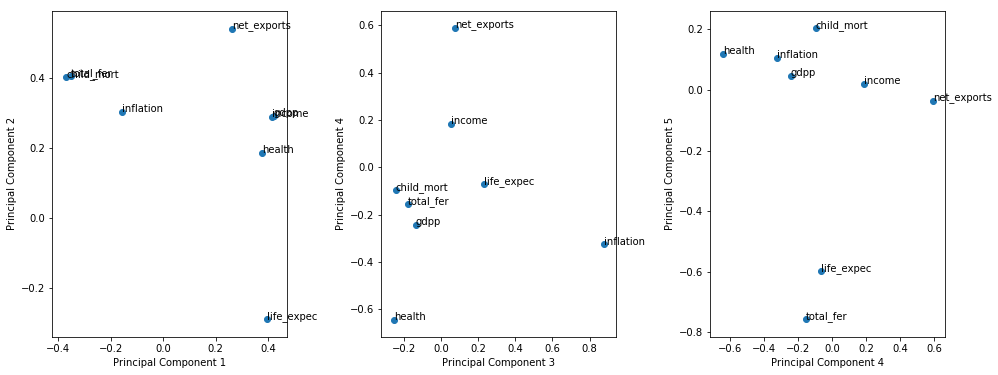

In [28]:
#The plots below show the relative contribution of features in different PCs
%matplotlib inline
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))

plt.subplot(1,3,2)
plt.scatter(pcs_df1.PC3, pcs_df1.PC4)
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df1.PC3[i],pcs_df1.PC4[i]))

plt.subplot(1,3,3)
plt.scatter(pcs_df2.PC4, pcs_df2.PC5)
plt.xlabel('Principal Component 4')
plt.ylabel('Principal Component 5')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df2.PC4[i],pcs_df2.PC5[i]))
    
plt.subplots_adjust(wspace = .4)

* PC1 has high contribution, with respect to PC1, of 'life_expec' and PC2 has high contribution of other variables
* Relative to PC5, PC4 has higher contribution of 'life_expec' and 'total_fer'

#### Let's see the screeplot to assess the number of needed principal components

In [29]:
pca.explained_variance_ratio_

array([0.56932021, 0.19588152, 0.11142421, 0.06994002, 0.02786901,
       0.01361861, 0.01019684, 0.00174958])

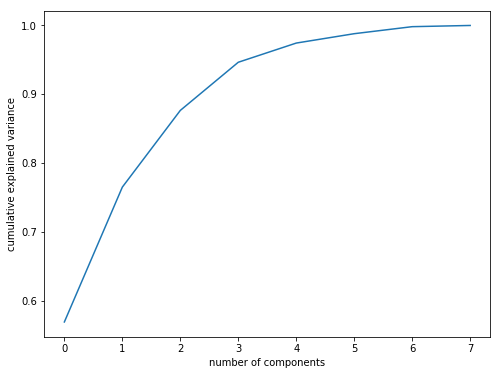

In [30]:
%matplotlib inline
fig = plt.figure(figsize = (8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### Looks like 4 components are enough to describe ~95% of the variance in the dataset
* We'll choose 4 components first for our modeling

#### Note: Minimum number of PCs required to explain 95% variance can also be determined by ---> 
* pca = PCA(0.95)
* pca.fit(df_scaled)
* pca.n_components_

In [31]:
pca_final = IncrementalPCA(n_components=4)

#### Basis transformation - getting the data onto our PCs

In [32]:
df_scaled_pca = pca_final.fit_transform(df_scaled)
print(df_scaled_pca.shape)
print(type(df_scaled_pca))

(167, 4)
<class 'numpy.ndarray'>


In [33]:
df_pca = pd.DataFrame(df_scaled_pca)
df_pca.columns = ['PC1', 'PC2', 'PC3', 'PC4']
df_pca.shape

(167, 4)

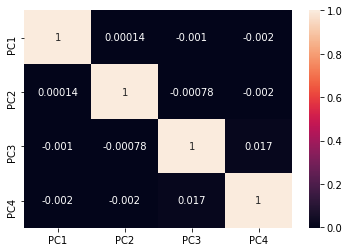

In [34]:
#Checking the correlations; there should not be any significant correlation.
sns.heatmap(df_pca.corr(), annot = True)

#### Indeed - Correlation coefficients are close to zero
- We effectively have removed multicollinearity, and our models will be much more stable now

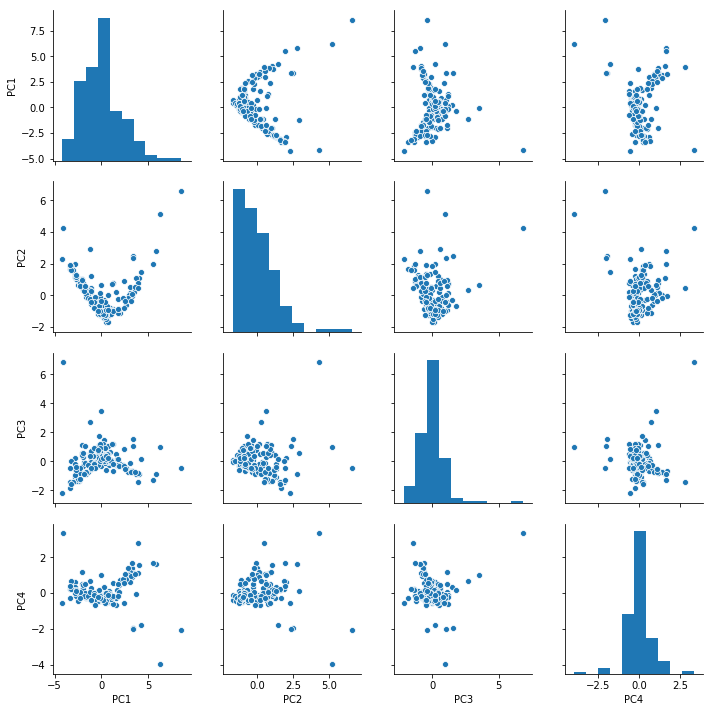

In [35]:
#### Let's visualize the PCs
sns.pairplot(df_pca)

* Seems difficult to identify the clusters visually. The probable reason could be that the df_pca is a multidimensional data and we are visualizing only two variables at a time, in 2D surface

## 3. Clustering
### 3.1 K-means:

#### Finding optimum number of clusters:
#### Elbow curve/SSD

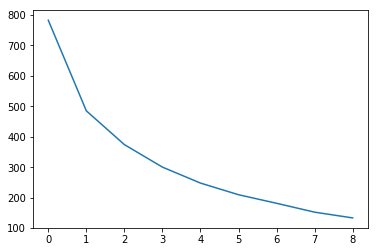

In [36]:
range_n_cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10]
ssd = []
for num_cluster in range_n_cluster:
    kmeans = KMeans(n_clusters = num_cluster, max_iter=50, random_state = 100)
    kmeans.fit(df_pca)
    ssd.append(kmeans.inertia_)

#plot the SSDs
plt.plot(ssd)

Although we can see a clear break corresponding to 3 clusters but we can give it a try for 3-5 clusters. 

#### Silhouette Analysis

In [37]:
for num_cluster in range_n_cluster:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_cluster, max_iter=50, random_state = 100)
    kmeans.fit(df_pca)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_cluster, silhouette_avg))

For n_clusters=2, the silhouette score is 0.45736394823938015
For n_clusters=3, the silhouette score is 0.4693165518973666
For n_clusters=4, the silhouette score is 0.4764377019136442
For n_clusters=5, the silhouette score is 0.47761266185323153
For n_clusters=6, the silhouette score is 0.3841402555091378
For n_clusters=7, the silhouette score is 0.36384616511421947
For n_clusters=8, the silhouette score is 0.3482527167627842
For n_clusters=9, the silhouette score is 0.37412777837786404
For n_clusters=10, the silhouette score is 0.38228383898111384


From the Silhoutte score also highest value obtained is for 3-5 clusters

### Let's move with 3 clusters first

In [38]:
kmeans = KMeans(n_clusters=3, max_iter=50, random_state = 100)
kmeans.fit(df_pca)
kmeans.labels_

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [39]:
df_pca_final_3 = df_corrected1.copy()
df_pca_final_3['labels_kmeans'] = kmeans.labels_

In [40]:
#Let's see numbers of countries in each cluster
print('Number of countries in cluster-0:', len(list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['country'])))
print('Number of countries in cluster-1:', len(list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['country'])))
print('Number of countries in cluster-2:', len(list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['country'])))

Number of countries in cluster-0: 26
Number of countries in cluster-1: 93
Number of countries in cluster-2: 48


#### Let's compare the clusters with each others

In [41]:
child_mort_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['child_mort'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['child_mort'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['child_mort'].mean()]

net_exports_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['net_exports'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['net_exports'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['net_exports'].mean()]

health_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['health'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['health'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['health'].mean()]

income_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['income'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['income'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['income'].mean()]

inflation_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['inflation'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['inflation'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['inflation'].mean()]

life_expec_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['life_expec'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['life_expec'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['life_expec'].mean()]

total_fer_list = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['total_fer'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['total_fer'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['total_fer'].mean()]

gdpp = [df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['gdpp'].mean(), 
                   df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['gdpp'].mean(),
                  df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['gdpp'].mean()]

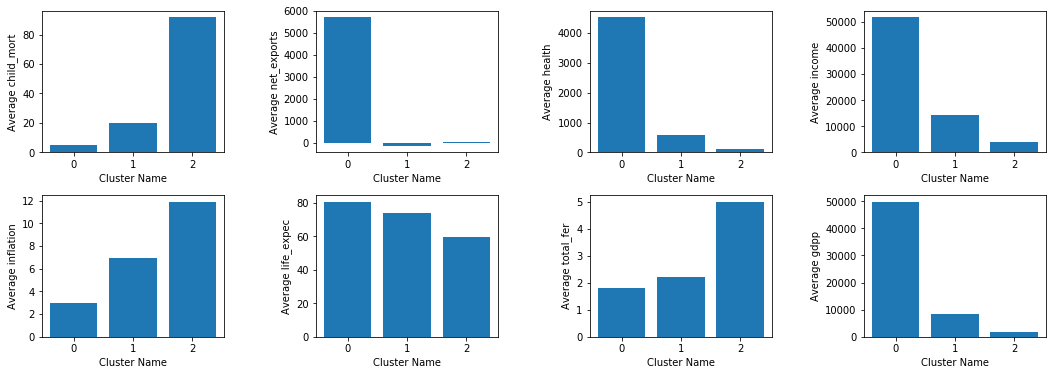

In [42]:
clusters = [0, 1, 2]

fig = plt.figure(figsize = (18,6))
plt.subplot(2,4,1)
plt.bar(clusters, child_mort_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average child_mort')

plt.subplot(2,4,2)
plt.bar(clusters, net_exports_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average net_exports')

plt.subplot(2,4,3)
plt.bar(clusters, health_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average health')

plt.subplot(2,4,4)
plt.bar(clusters, income_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average income')

plt.subplot(2,4,5)
plt.bar(clusters, inflation_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average inflation')

plt.subplot(2,4,6)
plt.bar(clusters, life_expec_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average life_expec')

plt.subplot(2,4,7)
plt.bar(clusters, total_fer_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average total_fer')

plt.subplot(2,4,8)
plt.bar(clusters, gdpp)
plt.xlabel('Cluster Name')
plt.ylabel('Average gdpp')

plt.subplots_adjust(wspace = .5, hspace = .3)

#### Conclusions from the 3 clusters solution:
* Cluster-2: It has 48 countries and this group has highest average 'child_mort' & 'inflation' and this group lags behind in all other 'good/possitive' variables.
* So,we can name this cluster as <span style="color:red">'Backward Countries'</span>
* Cluster-1: It has 93 countries and this group lies in the second position along all the variables.
* Let's name this group as <span style="color:red">'Developing Countries'</span>
* Cluster-0: It has 26 countries and this group has highest avaerage 'net_exports', 'health', 'income', 'life_expec', and 'gdpp'. At the same time this group rankes lowest by considering negative factors like 'child_mort' and 'inflation'
* This group is the <span style="color:red">'Developed Countries'</span>

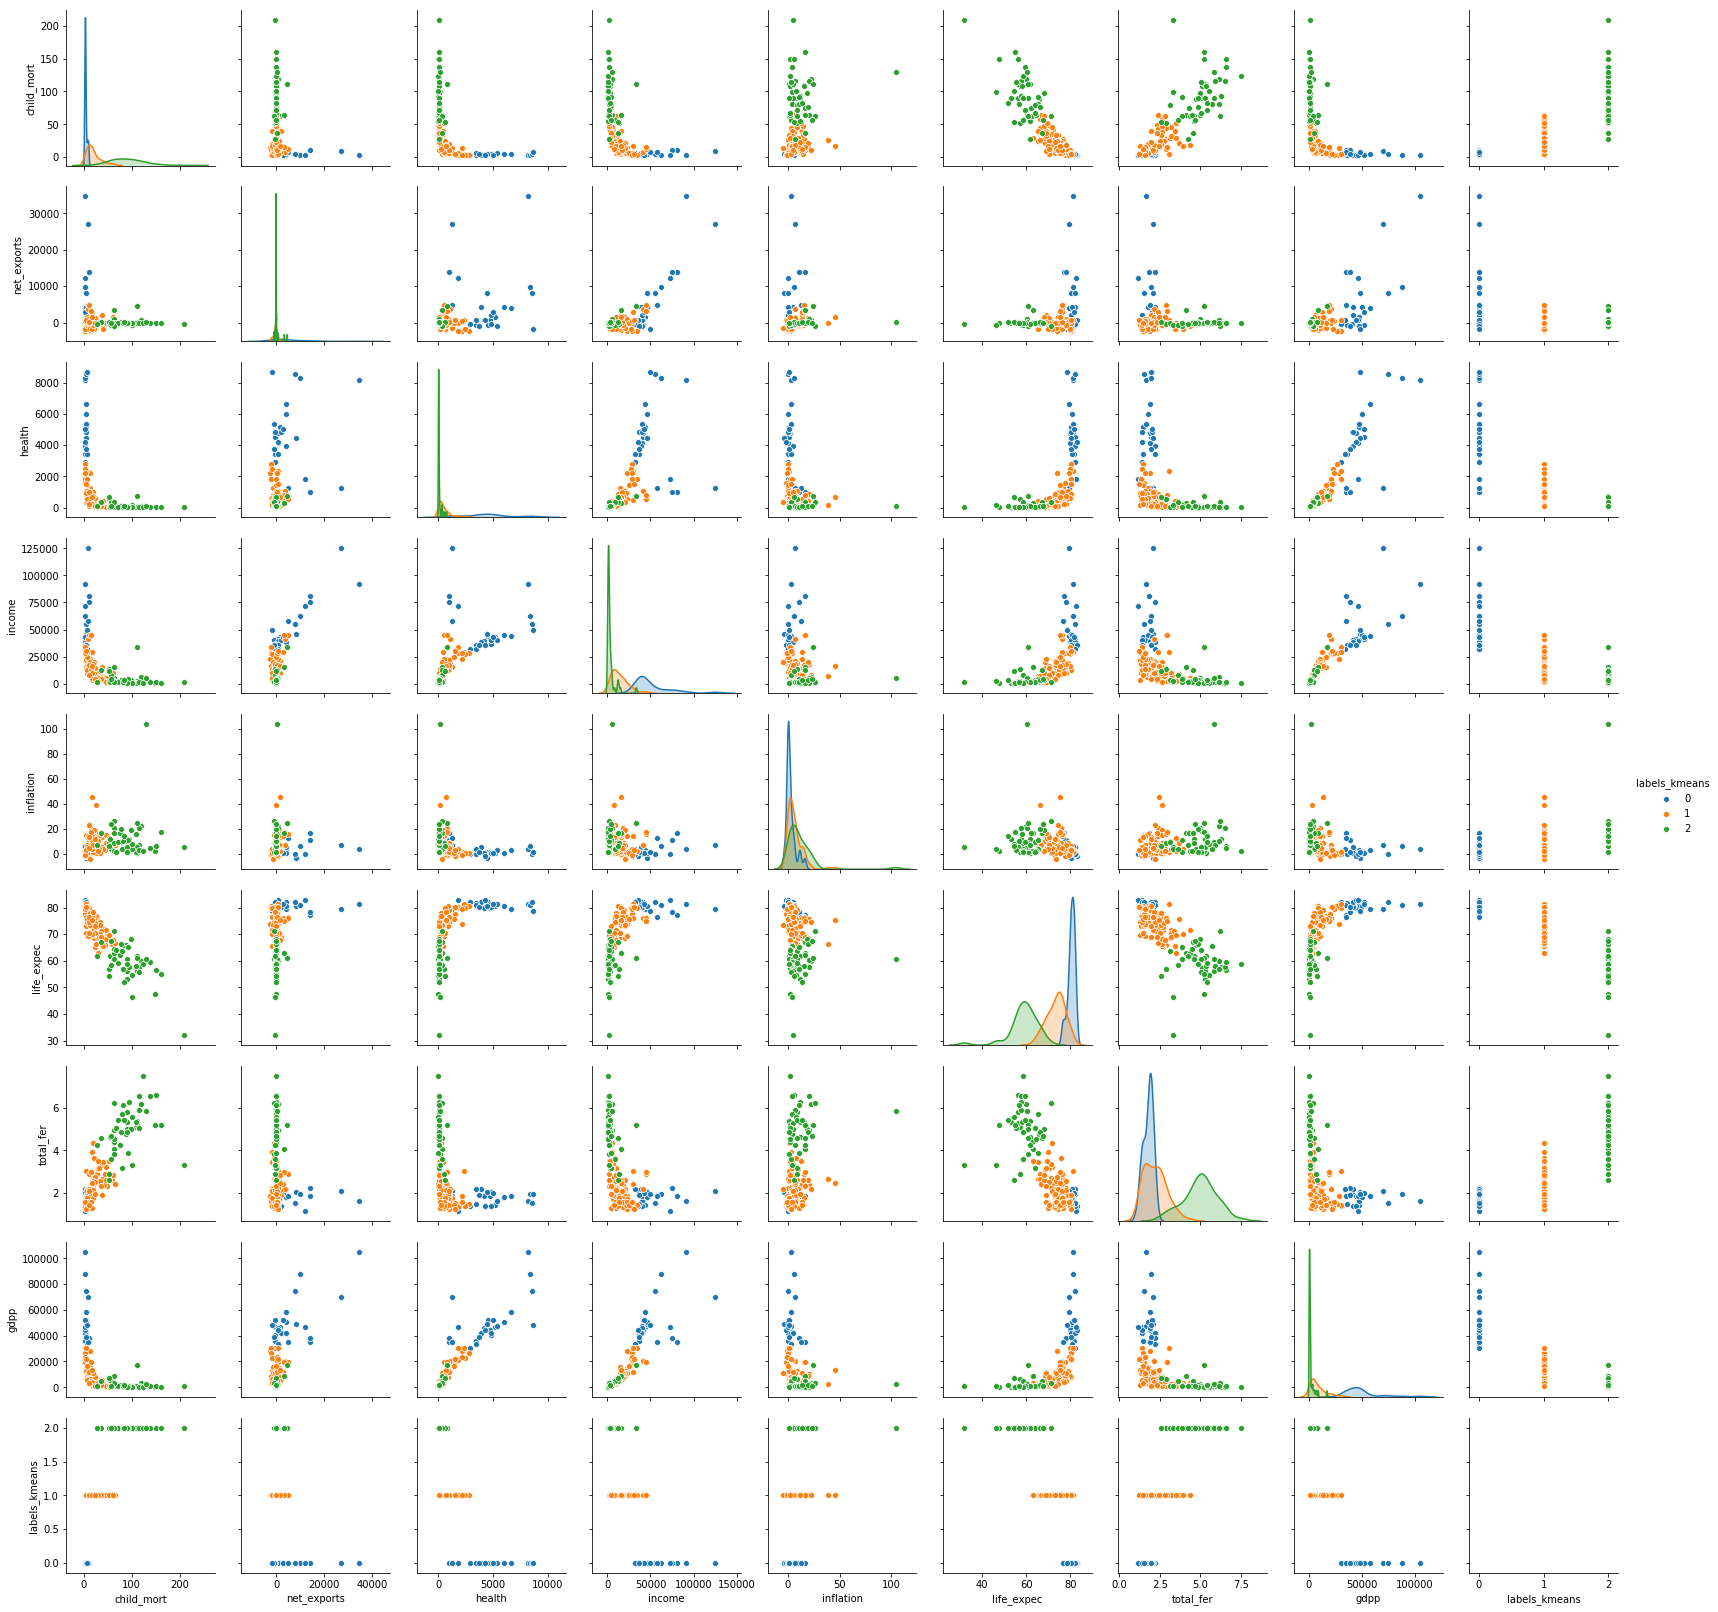

In [43]:
#Below is another one type of visualization of the clusters
data = df_pca_final_3[['child_mort', 'net_exports', 'health', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp', 'labels_kmeans']]
sns.pairplot(data, hue = 'labels_kmeans')

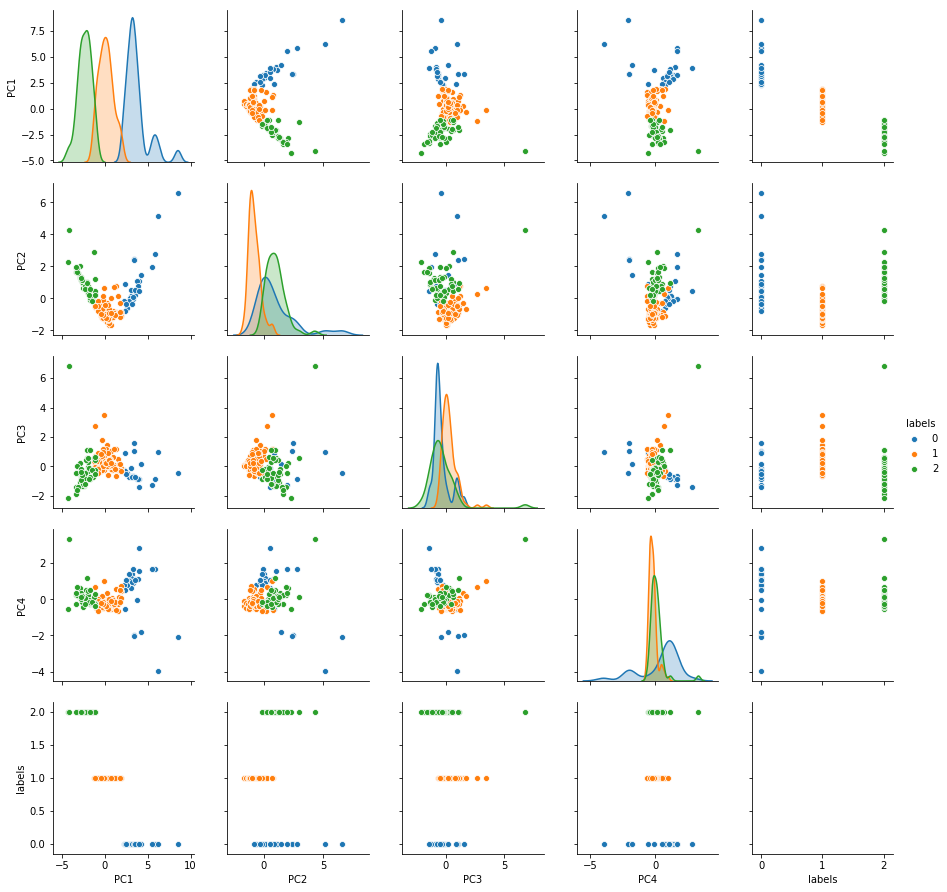

In [44]:
#Let's visulaze the clusters with PCs
df_pca1 = pd.DataFrame(df_scaled_pca)
df_pca1.columns = ['PC1', 'PC2', 'PC3', 'PC4']
df_pca1['labels'] = kmeans.labels_
sns.pairplot(df_pca1, hue = 'labels')

#### Its time to see which countries belong to which cluster

In [45]:
#Countries in cluster-2
prGreen('\033[1m Countries in Cluster-2 (Backward Countries) ---> \033[0m')
print(list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['country']))

  Countries in Cluster-2 (Backward Countries) ---> 
['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


In [46]:
#Countries in cluster-1
prGreen('\033[1m Countries in Cluster-1 (Developing Countries) ---> \033[0m')
print(list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 1]['country']))

  Countries in Cluster-1 (Developing Countries) ---> 
['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Georgia', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India', 'Indonesia', 'Iran', 'Israel', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Macedonia, FYR', 'Malaysia', 'Maldives', 'Malta', 'Mauritius', 'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Myanmar', 'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles', 'Slovak Republic', 'Slovenia', 'So

In [47]:
#Countries in cluster-0
prGreen('\033[1m Countries in Cluster-0 (Developed Countries) ---> \033[0m')
print(list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 0]['country']))

  Countries in Cluster-0 (Developed Countries) ---> 
['Australia', 'Austria', 'Belgium', 'Brunei', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Kuwait', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Qatar', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']


### Let's  consider the possibility 4 clusters now

In [48]:
#Let's move with 4 clusters first
kmeans = KMeans(n_clusters=4, max_iter=50, random_state = 100)
kmeans.fit(df_pca)
df_pca_final_4 = df_corrected1.copy()
df_pca_final_4['labels_kmeans'] = kmeans.labels_

In [49]:
print('Number of countries in cluster-0:', len(list(df_pca_final_4[df_pca_final_4['labels_kmeans'] == 0]['country'])))
print('Number of countries in cluster-1:', len(list(df_pca_final_4[df_pca_final_4['labels_kmeans'] == 1]['country'])))
print('Number of countries in cluster-2:', len(list(df_pca_final_4[df_pca_final_4['labels_kmeans'] == 2]['country'])))
print('Number of countries in cluster-3:', len(list(df_pca_final_4[df_pca_final_4['labels_kmeans'] == 3]['country'])))

Number of countries in cluster-0: 48
Number of countries in cluster-1: 91
Number of countries in cluster-2: 23
Number of countries in cluster-3: 5


#### Conclusion with 4 clusters (K-Means): 
With the 3 clusters solution we had a distribution of 48, 93 & 23 countries in three clusters. It seems that the 4 clusters solution just granulated and generated a cluster with 5 countries only. So, logically moving from 3 to 4 clusters solutions do not add much value.

### Let's consider 5 clusters now

In [50]:
kmeans = KMeans(n_clusters=5, max_iter=50, random_state = 100)
kmeans.fit(df_pca)
df_pca_final_5 = df_corrected1.copy()
df_pca_final_5['labels_kmeans'] = kmeans.labels_

In [51]:
print('Number of countries in cluster-0:', len(list(df_pca_final_5[df_pca_final_5['labels_kmeans'] == 0]['country'])))
print('Number of countries in cluster-1:', len(list(df_pca_final_5[df_pca_final_5['labels_kmeans'] == 1]['country'])))
print('Number of countries in cluster-2:', len(list(df_pca_final_5[df_pca_final_5['labels_kmeans'] == 2]['country'])))
print('Number of countries in cluster-3:', len(list(df_pca_final_5[df_pca_final_5['labels_kmeans'] == 3]['country'])))
print('Number of countries in cluster-4:', len(list(df_pca_final_5[df_pca_final_5['labels_kmeans'] == 4]['country'])))

Number of countries in cluster-0: 28
Number of countries in cluster-1: 89
Number of countries in cluster-2: 47
Number of countries in cluster-3: 2
Number of countries in cluster-4: 1


#### Conclusion with 5 clusters (K-means): 
In cluster-4 we have only one country and it does not make much sense to go with this clustering solution.

### 3.2 Hierarchical

#### 3.2.1 Single linkage

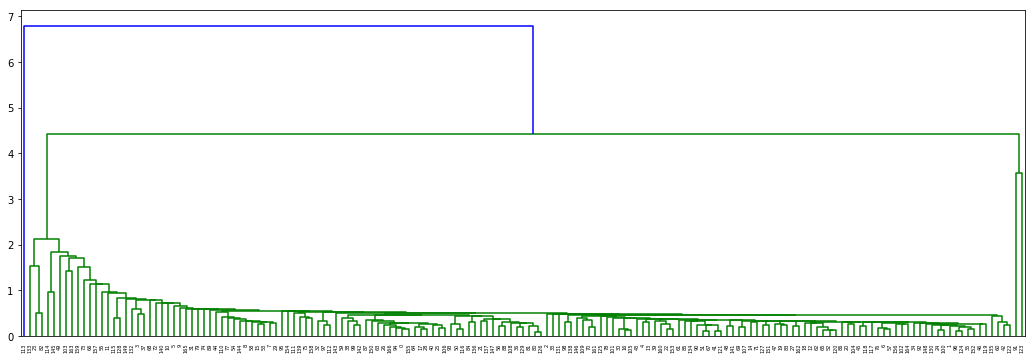

In [52]:
fig = plt.figure(figsize = (18,6))
mergings_single = linkage(df_pca, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()

In [53]:
#Trying for 3 clusters
labels_single = cut_tree(mergings_single, n_clusters=3).reshape(-1, )
labels_single

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
df_pca_final_single_3 = df_corrected1.copy()
df_pca_final_single_3['labels_single_hierarchical'] = labels_single

In [55]:
print('Number of countries in cluster-0:', len(list(df_pca_final_single_3[df_pca_final_single_3['labels_single_hierarchical'] == 0]['country'])))
print('Number of countries in cluster-1:', len(list(df_pca_final_single_3[df_pca_final_single_3['labels_single_hierarchical'] == 1]['country'])))
print('Number of countries in cluster-2:', len(list(df_pca_final_single_3[df_pca_final_single_3['labels_single_hierarchical'] == 2]['country'])))

Number of countries in cluster-0: 164
Number of countries in cluster-1: 2
Number of countries in cluster-2: 1


#### Conclusion with 3 clusters (Hierarchical, Single): 
We can see that cluster-2 has only 1 country and cluster-1 has only 2 countries. So, it does not make any sense to go with this kind of clustering.

#### 3.2.2 Complete linkage

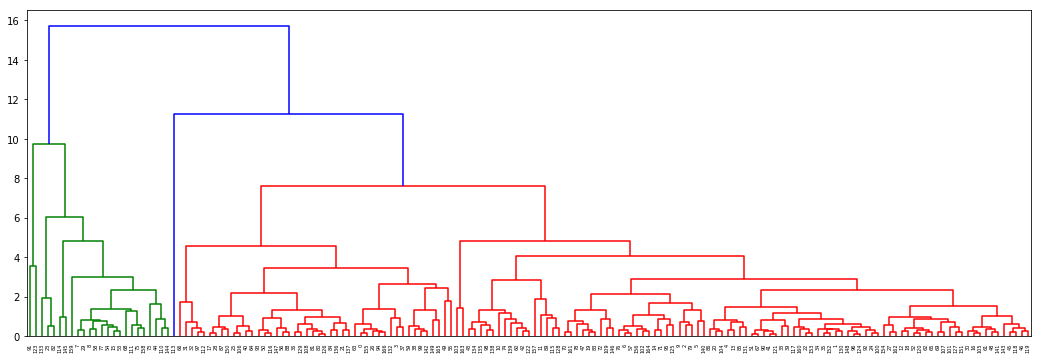

In [56]:
fig = plt.figure(figsize = (18,6))
mergings_complete = linkage(df_pca, method="complete", metric='euclidean')
dendrogram(mergings_complete)
plt.show()

#### Three Clusters

In [57]:
labels_complete = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
labels_complete

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [58]:
df_pca_final_complete_3 = df_corrected1.copy()
df_pca_final_complete_3['labels_complete_hierarchical'] = labels_complete

In [59]:
print('Number of countries in cluster-0:', len(list(df_pca_final_complete_3[df_pca_final_complete_3['labels_complete_hierarchical'] == 0]['country'])))
print('Number of countries in cluster-1:', len(list(df_pca_final_complete_3[df_pca_final_complete_3['labels_complete_hierarchical'] == 1]['country'])))
print('Number of countries in cluster-2:', len(list(df_pca_final_complete_3[df_pca_final_complete_3['labels_complete_hierarchical'] == 2]['country'])))

Number of countries in cluster-0: 142
Number of countries in cluster-1: 24
Number of countries in cluster-2: 1


Again here we can see cluster-2 has only one country. So better not to go with this solution

#### Four Clusters

In [60]:
labels_complete = cut_tree(mergings_complete, n_clusters=4).reshape(-1, )
labels_complete

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [61]:
df_pca_final_complete_4 = df_corrected1.copy()
df_pca_final_complete_4['labels_complete_hierarchical'] = labels_complete

In [62]:
print('Number of countries in cluster-0:', len(list(df_pca_final_complete_4[df_pca_final_complete_4['labels_complete_hierarchical'] == 0]['country'])))
print('Number of countries in cluster-1:', len(list(df_pca_final_complete_4[df_pca_final_complete_4['labels_complete_hierarchical'] == 1]['country'])))
print('Number of countries in cluster-2:', len(list(df_pca_final_complete_4[df_pca_final_complete_4['labels_complete_hierarchical'] == 2]['country'])))
print('Number of countries in cluster-3:', len(list(df_pca_final_complete_4[df_pca_final_complete_4['labels_complete_hierarchical'] == 3]['country'])))

Number of countries in cluster-0: 142
Number of countries in cluster-1: 22
Number of countries in cluster-2: 2
Number of countries in cluster-3: 1


#### Again 4 clusters also did not provide good result. Going further to more number of cluster will make everything too granular

## 4. Final Conclusion:

#### K-means with three cluster produced best logical result
* It can clearly identify 'Backward Countries', 'Developing Countries' and the 'Developed Countries'

#### Let's go ahead and try to make recommendation to the CEO:

In [63]:
#Here is the list of 'Backward Countries'
lst = list(df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]['country'])
print(len(lst))
print(lst)

48
['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


In [64]:
df_final_backward = df_pca_final_3[df_pca_final_3['labels_kmeans'] == 2]
df_final_backward.head()

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,net_exports,labels_kmeans
0,Afghanistan,90.2,41.9174,1610,9.440,56.2,5.82,553,-192.997,2
3,Angola,119.0,100.6050,5900,22.400,60.1,6.16,3530,684.820,2
17,Benin,111.0,31.0780,1820,0.885,61.8,5.36,758,-101.572,2
21,Botswana,52.5,527.0500,13300,8.920,57.1,2.88,6350,-488.950,2
25,Burkina Faso,116.0,38.7550,1430,6.810,57.9,5.87,575,-59.800,2


As per the problem statement, the HELP international is trying to give aid to the 'Backward Countries' with <span style="color:red">basic amenities</span> and <span style="color:red">relief</span> during the time of <span style="color:red">disasters and natural calamities</span>.
* So to fulfil this goal we might need to identify the countries with low budget for health, and low income. There is no way we can convert the 'income' to its purchasing power and that is why we will keep 'inflation' out of the equation now.
* Let's keep these two columns only go ahead with the analysis

In [65]:
df_final_backward = df_final_backward[['country', 'health', 'income']]
df_final_backward.head()

,country,health,income
0,Afghanistan,41.9174,1610
3,Angola,100.6050,5900
17,Benin,31.0780,1820
21,Botswana,527.0500,13300
25,Burkina Faso,38.7550,1430


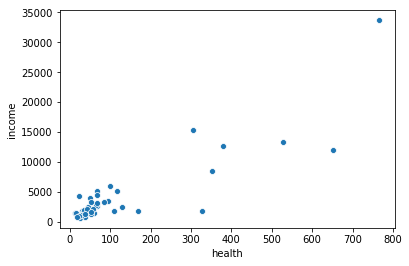

In [66]:
sns.scatterplot(x = df_final_backward['health'], y = df_final_backward['income'])

In [67]:
df_final_backward = df_final_backward[df_final_backward['income'] < np.percentile(df_final_backward.income,25)].sort_values(by='income')
df_final_backward.head(10)

,country,health,income
37,"Congo, Dem. Rep.",26.4194,609
88,Liberia,38.5860,700
26,Burundi,26.7960,764
112,Niger,17.9568,814
31,Central African Republic,17.7508,888
106,Mozambique,21.8299,918
94,Malawi,30.2481,1030
63,Guinea,31.9464,1190
150,Togo,37.3320,1210
132,Sierra Leone,52.2690,1220


In [68]:
#So, following are the countries which can be recommended to the CEO
list(df_final_backward['country'])

['Congo, Dem. Rep.',
 'Liberia',
 'Burundi',
 'Niger',
 'Central African Republic',
 'Mozambique',
 'Malawi',
 'Guinea',
 'Togo',
 'Sierra Leone',
 'Rwanda']